## Part IV bag of words NLP rating model

### 4.1 modeling using tfidf transformed data

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from numpy import arange
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
#load data and scale data
X_train=pd.read_csv('data/tfidf_train_X.csv')
y_train=pd.read_csv('data/y_train.csv')
X_test=pd.read_csv('data/tfidf_test_X.csv')
y_test=pd.read_csv('data/y_test.csv')

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
st_scaler=StandardScaler()
X_train_s=st_scaler.fit_transform(X_train)
X_test_s=st_scaler.transform(X_test)

In [5]:
X_train_s.shape

(41191, 298)

In [6]:
y_train.shape

(41191, 1)

#### 4.1.1 Regularized Linear regression model

 ElasticNet regularization applies both L1-norm and L2-norm regularization to penalize the coefficients in a regression model.  ElasticNetCV is a cross-validation class that can search multiple alpha values and applies the best one. We'll define the model with alphas value and fit it with xtrain and ytrain data. More details about ElasticNet model can be found [here](https://machinelearningmastery.com/elastic-net-regression-in-python/).

In [7]:
import warnings
warnings.filterwarnings("ignore")
import time
alphas = [0.0001, 0.001, 0.01, 0.1, 0.4, 0.8, 1, 10, 100]
l1_ratios = arange(0, 1, 0.01)
start=time.time()
en_cv=ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, n_jobs=-1)
best_m = en_cv.fit(X_train_s, y_train)
end=time.time()
print(best_m.alpha_)
print(best_m.l1_ratio_)
print(f"Runtime of the program is {end - start}")

0.01
0.28
Runtime of the program is 194.99249267578125


In [8]:
y_pre = best_m.predict(X_test_s)
mse=mean_squared_error(y_test, y_pre)
mae=mean_absolute_error(y_test, y_pre)
r2 = r2_score(y_test, y_pre)
print('MSE: %f' % mse)
print('MAE:%f'% mae)
print('R^2: %f' % r2)

MSE: 6.117673
MAE:1.993788
R^2: 0.429545


286 features, reduction of 4.03%


<AxesSubplot:>

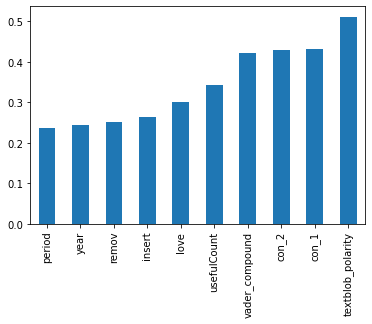

In [9]:
#important features in the models
feature_importance = pd.Series(index = X_train.columns, data = np.abs(best_m.coef_))
N_se_feature = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(N_se_feature,(1-N_se_feature/len(feature_importance))*100))
feature_importance.sort_values().tail(10).plot(kind = 'bar')

No wonder the result is not good. love, insert, remov and period are listed as the top important features in the model. We can connect them with birth control drugs only.

#### 4.1.2 Decision tree model

In [10]:
param_grid = {'max_depth':[4,8,12, 20, 100, 200]}
start=time.time()
tree_cv = RandomizedSearchCV(DecisionTreeRegressor(criterion='mse'), param_grid , cv=5, random_state=42)
tree_cv.fit(X_train_s,y_train)
end=time.time()
print("BEST PARAMS", tree_cv.best_params_)
print(f"Runtime of the program is {end - start}")

BEST PARAMS {'max_depth': 200}
Runtime of the program is 173.41510486602783


In [11]:
def DecisionTreeRegressor_R(train_x, train_y, test_x, test_y, max_depth):
    decision = DecisionTreeRegressor(criterion='mse', max_depth=max_depth)
    decision.fit(train_x, train_y)
    train_pred = decision.predict(train_x)
    test_pred = decision.predict(test_x)
    test_mse = mean_squared_error(test_y, test_pred)
    test_mae = mean_absolute_error(test_y, test_pred)
    test_r2 = r2_score(test_y, test_pred)      
    print("test set results: MSE: %f, MAE: %f, R^2: %f" % (test_mse, test_mae, test_r2))     

In [12]:
DecisionTreeRegressor_R(X_train_s, y_train, X_test_s, y_test, 100)

test set results: MSE: 5.008383, MAE: 0.971111, R^2: 0.532983


<AxesSubplot:>

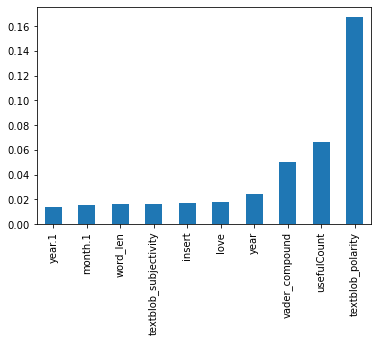

In [14]:
tree = DecisionTreeRegressor(criterion='mse', max_depth=200)
tree.fit(X_train_s,y_train)
feature_importance = pd.Series(index = X_train.columns, data = np.abs(tree.feature_importances_))
feature_importance.sort_values().tail(10).plot(kind = 'bar')

Decision tree gave us better results than linear regression. But it is still not a good model considering the low r2 values for the test set. Similar to linear regression, usefulcount, textblob_polarity, vader_compound are listed as the top features.

#### 4.1.3 support vector machine for regression

In [15]:
start=time.time()
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train_s, y_train)
y_pred = regressor.predict(X_test_s)
end=time.time()
print(f"Runtime of the program is {end - start}")

Runtime of the program is 1963.2922508716583


In [16]:
mse=mean_squared_error(y_test, y_pre)
mae=mean_absolute_error(y_test, y_pre)
r2 = r2_score(y_test, y_pre)
print('MSE: %f' % mse)
print('MAE:%f'% mae)
print('R^2: %f' % r2)

MSE: 6.117673
MAE:1.993788
R^2: 0.429545


People usually suggested to use linear kernels if the number of features is larger than the number of observations in the dataset (otherwise RBF might be a better choice). But RBF, Radial Basis Function, based SVM is really time-consuming.

### 4.2 model using tfidf LSA transformed data

#### 4.2.1 regularized linear regression

In [18]:
#load data and scale data
X_train=pd.read_csv('data/tfidf_lsa_train_X.csv')
X_test=pd.read_csv('data/tfidf_lsa_test_X.csv')
X_train_s=st_scaler.fit_transform(X_train)
X_test_s=st_scaler.transform(X_test)

In [19]:
start=time.time()
en_cv=ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, n_jobs=-1)
best_m = en_cv.fit(X_train_s, y_train)
end=time.time()
print(best_m.alpha_)
print(best_m.l1_ratio_)
print(f"Runtime of the program is {end - start}")

0.001
0.86
Runtime of the program is 52.71996283531189


In [20]:
y_pre = best_m.predict(X_test_s)
mse=mean_squared_error(y_test, y_pre)
mae=mean_absolute_error(y_test, y_pre)
r2 = r2_score(y_test, y_pre)
print('MSE: %f' % mse)
print('MAE:%f'% mae)
print('R^2: %f' % r2)

MSE: 6.382285
MAE:2.043237
R^2: 0.404871


110 features, reduction of 0.00%


<AxesSubplot:>

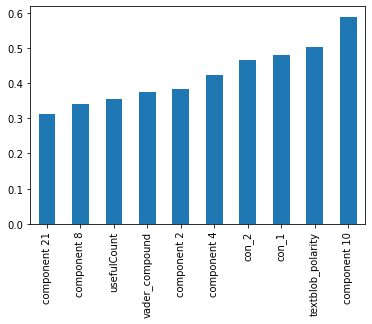

In [21]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(best_m.coef_))
N_se_feature = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(N_se_feature,(1-N_se_feature/len(feature_importance))*100))
feature_importance.sort_values().tail(10).plot(kind = 'bar')

#### 4.2.2 Decision tree

In [22]:
param_grid = {'max_depth':[4,8,12, 20, 100, 200]}
start=time.time()
tree_cv = RandomizedSearchCV(DecisionTreeRegressor(criterion='mse'), param_grid , cv=5, random_state=42)
tree_cv.fit(X_train_s,y_train)
end=time.time()
print("BEST PARAMS", tree_cv.best_params_)
print(f"Runtime of the program is {end - start}")

BEST PARAMS {'max_depth': 200}
Runtime of the program is 138.5398907661438


In [23]:
DecisionTreeRegressor_R(X_train_s, y_train, X_test_s, y_test, 100)

test set results: MSE: 5.246743, MAE: 1.004758, R^2: 0.510757


<AxesSubplot:>

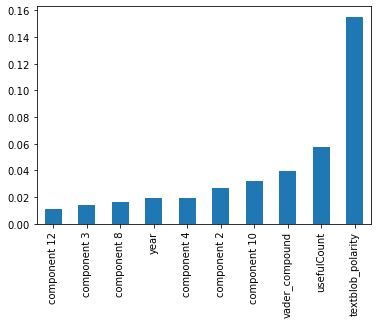

In [25]:
tree = DecisionTreeRegressor(criterion='mse', max_depth=200)
tree.fit(X_train_s,y_train)
feature_importance = pd.Series(index = X_train.columns, data = np.abs(tree.feature_importances_))
feature_importance.sort_values().tail(10).plot(kind = 'bar')

#### 4.2.3 support vector machine

There are three important hyperparameters in SVM:  “kernel”, “gamma” and “C”
kernel:rbf, poly, sigmoid
gamma: Higher the value of gamma, higher possibility of overfitting.
C: Penalty parameter of the error term. It helps to controls the trade-off between accuracy and overfitting

In [26]:
from sklearn.svm import SVR
start=time.time()
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train_s, y_train)
y_pred = regressor.predict(X_test_s)
end=time.time()
print(f"Runtime of the program is {end - start}")

Runtime of the program is 804.5845630168915


In [27]:
mse=mean_squared_error(y_test, y_pre)
mae=mean_absolute_error(y_test, y_pre)
r2 = r2_score(y_test, y_pre)
print('MSE: %f' % mse)
print('MAE:%f'% mae)
print('R^2: %f' % r2)

MSE: 6.382285
MAE:2.043237
R^2: 0.404871


SVM is very time-consuming.

I have to give up developing NLP regression model using ensembled algorithms like random forest or gradient boosting because they are really time-consuming. Let's try convert the problem into classification. We will convert the rating data into two levels, positive and negative. Hopefully, it can make our life easier.

In [28]:
y_train.loc[(y_train['rating'] >= 5), 'rating_class'] = 1
y_train.loc[(y_train['rating'] < 5), 'rating_class'] = 0
y_train.head()

,rating,rating_class
0,10.0,1.0
1,5.0,1.0
2,5.0,1.0
3,9.0,1.0
4,9.0,1.0


In [29]:
y_test.loc[(y_test['rating'] >= 5), 'rating_class'] = 1
y_test.loc[(y_test['rating'] < 5), 'rating_class'] = 0
y_test.head()

,rating,rating_class
0,10.0,1.0
1,8.0,1.0
2,3.0,0.0
3,1.0,0.0
4,9.0,1.0


In [30]:
y_train_c=y_train.drop(columns=['rating'])
y_test_c=y_test.drop(columns=['rating'])
y_train_c.head()

,rating_class
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [31]:
y_train_c.to_csv('data/y_train_c', index=False)
y_test_c.to_csv('data/y_test_c', index=False)